# Simple demo of GroundingDINO + Segment Anything Model

In [1]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import supervision as sv

from openvino.runtime import Core

In [2]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [3]:
import openvino as ov
import openvino.properties as props

In [5]:
ov.Core().set_property({props.cache_dir: './models/'})
ov.Core().get_property(props.cache_dir)

''

## Tokenizer

In [6]:
from tokenizers import Tokenizer
from typing import Union, List, Dict
class QuickTokenizer:
    def __init__(self, tokenizer_file):
        self._tokenizer = Tokenizer.from_file(tokenizer_file)
        self.unk_token_id = self._tokenizer.token_to_id('[UNK]')
    def __call__(self, text_prompt: Union[str, List[str]], return_tensors=None) -> Union[Dict, List[Dict]]:
        if text_prompt is None:
            return None
        if isinstance(text_prompt, str):
            return self.encode(text_prompt, return_tensors=return_tensors)
        return [self.encode(token) for token in text_prompt]
    def decode(self, ids: List[int]) -> str:
        return self._tokenizer.decode(ids)
    def encode(self, text_prompt: str, return_tensors=None) -> Dict:
        encoded = self._tokenizer.encode(text_prompt)
        if encoded is None:
            return self.unk_token_id
        res = {}
        if return_tensors == 'np':
            res["input_ids"] = np.asarray([encoded.ids])
            res["attention_mask"] = np.asarray([encoded.attention_mask])
            res["token_type_ids"] = np.asarray([encoded.type_ids])
        else:
            res["input_ids"] = encoded.ids
            res["attention_mask"] = encoded.attention_mask
            res["token_type_ids"] = encoded.type_ids
        return res
    def convert_tokens_to_ids(self, tokens: List[str]) -> List[int]:
        return [self._tokenizer.token_to_id(t) for t in tokens]

## GroundingDINO

In [7]:
def normalize(arr, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    arr = arr.astype(np.float32)
    arr /= 255.0
    for i in range(3):
        arr[...,i] = (arr[...,i] - mean[i]) / std[i]
    return arr

def preprocess_image(input_image, shape=[512,512]):
    img = input_image.resize(shape, Image.Resampling.NEAREST)
    img = normalize(np.array(img))
    return img.transpose(2,0,1)

In [8]:
def load_image(image_path, shape=[512, 512]):
    image_pil = Image.open(image_path).convert("RGB")
    image = preprocess_image(image_pil)
    return image_pil, image

In [9]:
def load_model(model_checkpoint_path, device):
    core = Core()
    model_read = core.read_model(model_checkpoint_path)
    model = core.compile_model(model_read, device.upper())
    model.tokenizer = QuickTokenizer('./models/tokenizer_pretrained_pytorch/tokenizer.json')
    model.max_text_len = 256
    return model

In [10]:
model = load_model('./models/groundingdino_512_fp16.xml', 'GPU')

In [11]:
image_path = 'assets/cat_dog.jpeg'
image_shape = [512, 512]
image_pil, image = load_image(image_path, image_shape)

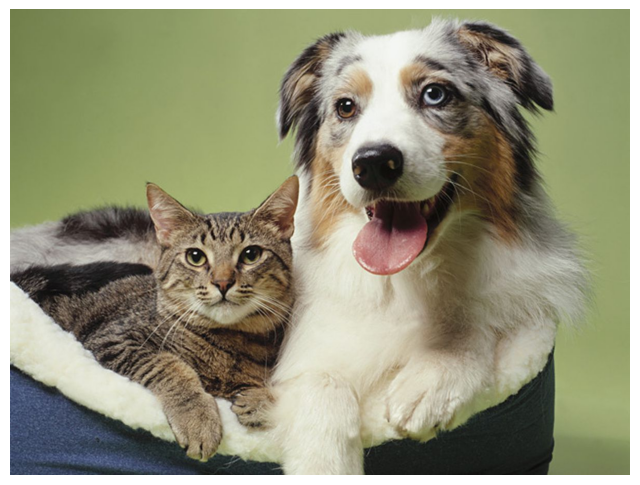

In [12]:
plt.figure(figsize=(8,8))
plt.imshow(np.array(image_pil))
plt.axis('off')
plt.show()

In [10]:
image_pil.size

(1200, 901)

In [13]:
text_prompt = "the cat and the dog."
box_threshold = 0.25
text_threshold = 0.25

In [14]:
def generate_masks(tokenized, special_tokens_list):
    input_ids = tokenized["input_ids"]
    bs, num_token = input_ids.shape
    # special_tokens_mask: bs, num_token. 1 for special tokens. 0 for normal tokens
    special_tokens_mask = np.zeros((bs, num_token)).astype(np.bool_)
    for special_token in special_tokens_list:
        special_tokens_mask |= input_ids == special_token

    # idxs: each row is a list of indices of special tokens
    idxs = np.transpose(np.nonzero(special_tokens_mask))

    # generate attention mask and positional ids
    attention_mask = np.repeat(np.eye(num_token).astype(np.bool_)[None], bs, axis=0)
    position_ids = np.zeros((bs, num_token), dtype=np.int64)
    previous_col = 0
    for i in range(idxs.shape[0]):
        row, col = idxs[i]
        if (col == 0) or (col == num_token - 1):
            attention_mask[row, col, col] = True
            position_ids[row, col] = 0
        else:
            attention_mask[row, previous_col + 1 : col + 1, previous_col + 1 : col + 1] = True
            position_ids[row, previous_col + 1 : col + 1] = np.arange(0, col - previous_col)
        previous_col = col

    return attention_mask, position_ids

In [15]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

In [16]:
from typing import Dict

def get_phrases_from_posmap(
            posmap: np.array,
            tokenized: Dict,
            tokenizer: QuickTokenizer,
            left_idx: int = 0, right_idx: int = 255):
    if posmap.ndim == 1:
        posmap[0: left_idx + 1] = False
        posmap[right_idx:] = False
        non_zero_idx = list(np.nonzero(posmap)[0])
        token_ids = [tokenized["input_ids"][i] for i in non_zero_idx]
        return tokenizer.decode(token_ids)
    else:
        raise NotImplementedError("posmap must be 1-dim")

In [17]:
def get_grounding_output(model, image, caption, box_threshold, text_threshold):
    caption = caption.lower().strip()
    if not caption.endswith("."):
        caption = caption + "."

    #tokenized = model.tokenizer(caption, padding="longest", return_tensors="np")
    tokenized = model.tokenizer(caption, return_tensors="np")
    specical_tokens = model.tokenizer.convert_tokens_to_ids(["[CLS]", "[SEP]", ".", "?"])
    
    text_self_attention_masks, position_ids = generate_masks(tokenized, specical_tokens)

    if text_self_attention_masks.shape[1] > model.max_text_len:
        text_self_attention_masks = text_self_attention_masks[
            :, : model.max_text_len, : model.max_text_len]
        
        position_ids = position_ids[:, : model.max_text_len]
        tokenized["input_ids"] = tokenized["input_ids"][:, : model.max_text_len]
        tokenized["attention_mask"] = tokenized["attention_mask"][:, : model.max_text_len]
        tokenized["token_type_ids"] = tokenized["token_type_ids"][:, : model.max_text_len]

    inputs = {}
    #input_img = np.expand_dims(image, 0)
    inputs["img"] = image[None]
    inputs["input_ids"] = tokenized["input_ids"]
    inputs["attention_mask"] = tokenized["attention_mask"]
    inputs["token_type_ids"] = tokenized["token_type_ids"]
    inputs["position_ids"] = position_ids
    inputs["text_token_mask"] = text_self_attention_masks 

    outputs = model.infer_new_request(inputs)

    prediction_logits_ = sigmoid(np.squeeze(outputs["logits"], 0)) # prediction_logits.shape = (nq, 256)
    prediction_boxes_ = np.squeeze(outputs["boxes"], 0) # prediction_boxes.shape = (nq, 4)

    # filter output
    mask = prediction_logits_.max(axis=1) > box_threshold
    logits = prediction_logits_[mask]  # num_filt, 256
    boxes = prediction_boxes_[mask]  # num_filt, 4

    # get phrase
    tokenized = model.tokenizer(caption)
    phrases = [get_phrases_from_posmap(logit > text_threshold, tokenized, model.tokenizer) for logit in logits]

    return boxes, logits.max(axis=1), phrases

In [18]:
boxes, logits, phrases = get_grounding_output(model, image, text_prompt, box_threshold, text_threshold)

In [19]:
def box_cxcywh_to_xyxy(boxes: np.ndarray) -> np.ndarray:
    cx,cy,w,h = np.transpose(boxes)
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    return np.transpose(np.array([x1,y1,x2,y2]))

In [20]:
from typing import List
def annotate(image_source: np.ndarray, boxes: np.ndarray, logits: np.ndarray, phrases: List[str]) -> np.ndarray:
    h, w, _ = image_source.shape
    boxes = boxes * np.array([w, h, w, h])
    xyxy = box_cxcywh_to_xyxy(boxes=boxes)
    detections = sv.Detections(xyxy=xyxy)

    labels = [
        f"{phrase} {logit:.2f}"
        for phrase, logit
        in zip(phrases, logits)
    ]

    box_annotator = sv.BoxAnnotator()
    #box_annotator.text_scale=0.5
    box_annotator.text_padding=0
    annotated_frame = box_annotator.annotate(scene=image_source, detections=detections, labels=labels)
    return annotated_frame

In [21]:
annotated_frame = annotate(image_source=np.asarray(image_pil), boxes=boxes, logits=logits, phrases=phrases)
image_with_box = Image.fromarray(annotated_frame)

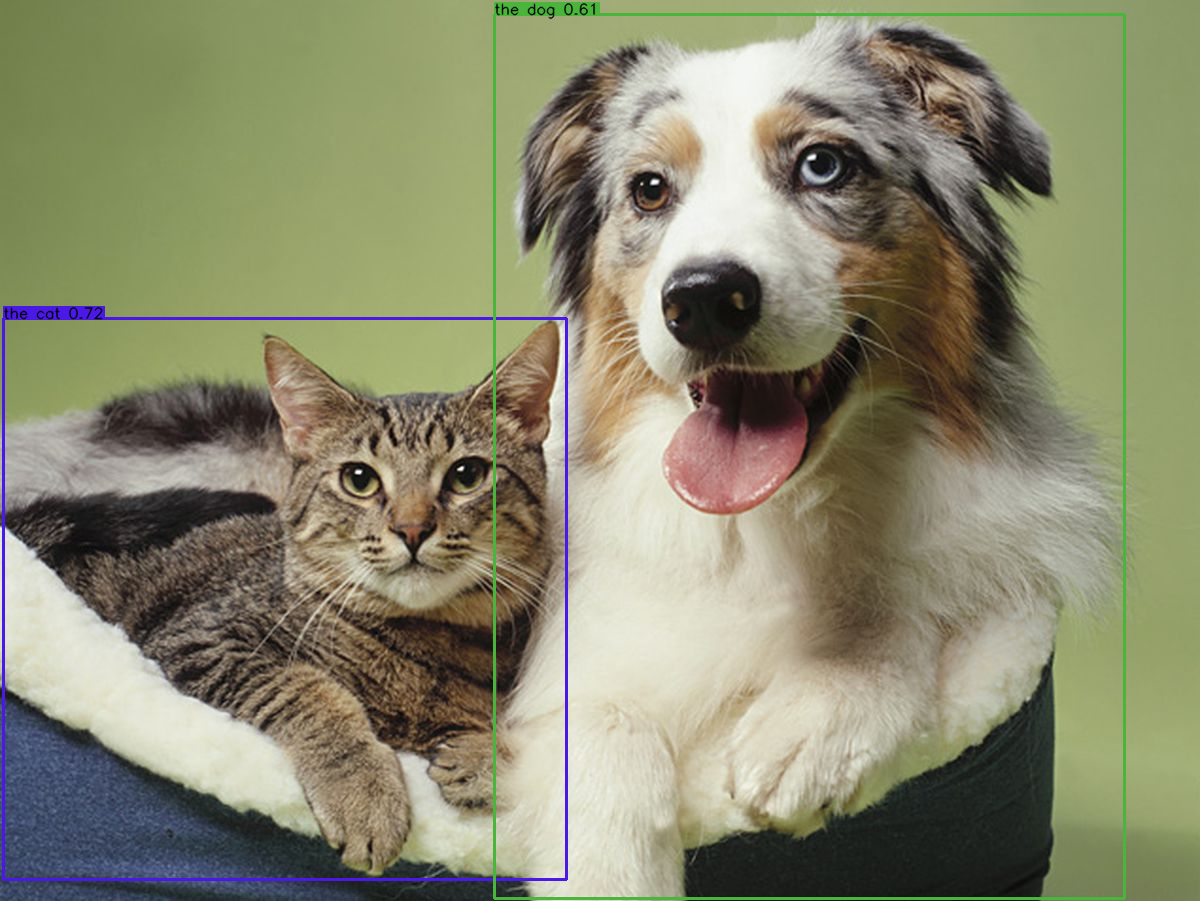

In [22]:
image_with_box

In [33]:
boxes

array([[0.23742676, 0.66503906, 0.46875   , 0.6220703 ],
       [0.6748047 , 0.50683594, 0.52490234, 0.98095703]], dtype=float32)

In [23]:
def post_process_result(
        source_h: int,
        source_w: int,
        boxes: np.ndarray,
        logits: np.ndarray
) -> sv.Detections:
    boxes = boxes * np.array([source_w, source_h, source_w, source_h])
    xyxy = box_cxcywh_to_xyxy(boxes)
    return sv.Detections(xyxy=xyxy, confidence=logits, class_id=np.array(range(boxes.shape[0])))

In [45]:
boxes.shape[0]

2

In [24]:
sw, sh = image_pil.size
detections = post_process_result(source_h=sh, source_w=sw, boxes=boxes, logits=logits)

In [25]:
detections.class_id

array([0, 1])

## Segment Anything Model

In [26]:
device = 'GPU'
model_type = 'vit_h'

In [27]:
core = Core()
sam_encoder_path = Path(f'./models/sam/sam_image_encoder_{model_type}.xml')
sam_predict_path = Path(f'./models/sam/sam_mask_predictor_{model_type}.xml')
sam_encoder_model = core.read_model(sam_encoder_path)
sam_predict_model = core.read_model(sam_predict_path)
sam_encoder = core.compile_model(sam_encoder_model, device)
sam_predict = core.compile_model(sam_predict_model, device)

In [28]:
from copy import deepcopy
class ResizeLongestSide:
    """
    Resizes images to longest side 'target_length', as well as provides
    methods for resizing coordinates and boxes. Provides methods for
    transforming numpy arrays.
    """
    def __init__(self, target_length: int) -> None:
        self.target_length = target_length

    def apply_image(self, image) -> np.ndarray:
        w, h = image.size
        w, h = self.get_preprocess_shape(w, h)
        return np.array(image.resize((w, h), Image.BILINEAR))

    def apply_coords(self, coords: np.ndarray, original_size) -> np.ndarray:
        """
        Expects a numpy array of length 2 in the final dimension. Requires the
        original image size in (H, W) format.
        """
        old_h, old_w = original_size
        new_h, new_w = self.get_preprocess_shape(original_size[0], original_size[1])
        coords = deepcopy(coords)
        coords[..., 0] = coords[..., 0] * (new_w / old_w)
        coords[..., 1] = coords[..., 1] * (new_h / old_h)
        return coords

    def get_preprocess_shape(self, x: int, y: int):
        scale = self.target_length * 1.0 / max(x, y)
        w, h = x * scale, y * scale
        w = int(w + 0.5)
        h = int(h + 0.5)
        return (w, h)

resizer = ResizeLongestSide(1024)

In [29]:
def sam_preprocess_image(image):
    resized_image = resizer.apply_image(image)
    resized_image = normalize(resized_image)
    resized_image = np.transpose(resized_image, (2, 0, 1))[None]
    # Pad
    h, w = resized_image.shape[-2:]
    padh = 1024 - h
    padw = 1024 - w
    x = np.pad(resized_image, ((0, 0), (0, 0), (0, padh), (0, padw)))
    return x

In [30]:
from skimage.transform import resize
def postprocess_masks(masks: np.ndarray, orig_size):
    size_before_pad = resizer.get_preprocess_shape(orig_size[0], orig_size[1])
    masks = masks[..., :int(size_before_pad[0]), :int(size_before_pad[1])]
    masks = resize(masks, (1, orig_size[0], orig_size[1]))
    return masks

In [31]:
#import cv2
#image = cv2.imread('assets/cat_dog.jpeg')
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = np.array(image_pil)
preprocessed_image = sam_preprocess_image(image_pil)
encoding_results = sam_encoder(preprocessed_image)
image_embeddings = encoding_results[sam_encoder.output(0)]

In [32]:
image_embeddings.shape

(1, 256, 64, 64)

In [53]:
masks = []
for box in detections.xyxy:
    coord = box.reshape(2,2)[None, :, :]
    label = np.array([2,3])[None, :].astype(np.float32)
    coord = resizer.apply_coords(coord, image.shape[:2])

    inputs = {
        "image_embeddings": image_embeddings,
        "point_coords": coord,
        "point_labels": label,
    }
    results = sam_predict(inputs)

    mask = results[sam_predict.output(0)][0]
    mask = postprocess_masks(mask, image.shape[:-1])
    mask = mask > 0.0
    masks.append(mask)

In [54]:
detections.xyxy

array([[   3.66210938,  318.95751953,  566.16210938,  879.44287109],
       [ 494.82421875,   14.73803711, 1124.70703125,  898.58032227]])

In [55]:
box_annotator = sv.BoxAnnotator()
box_annotator.text_padding=0
box_annotator.text_scale = 0.7
mask_annotator = sv.MaskAnnotator()
annotated_image = image.copy()
for mask in masks:
    detections.mask = mask
    annotated_image = mask_annotator.annotate(scene=annotated_image, detections=detections)
labels = [f"{p} {c:.2f}" for p, c in zip(phrases, detections.confidence.tolist())]
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)

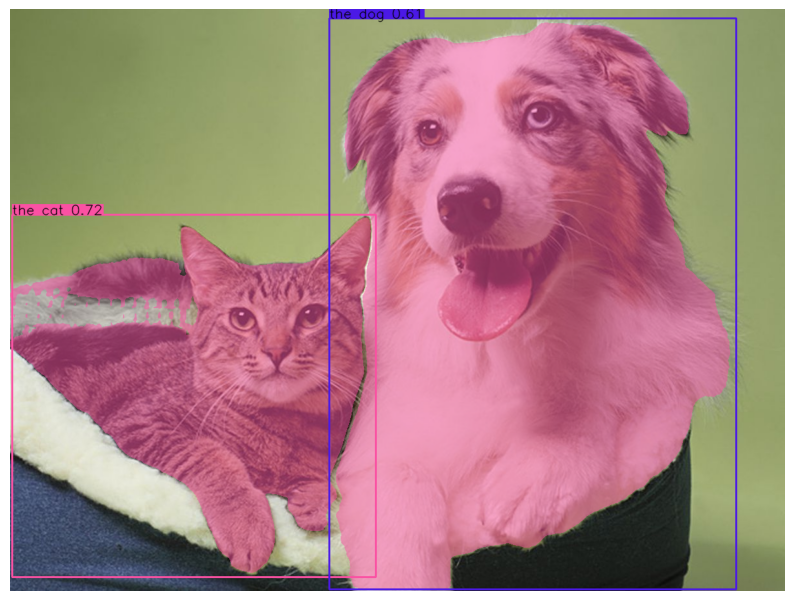

In [56]:
plt.figure(figsize=(10, 10))
plt.imshow(annotated_image)
plt.axis('off')
plt.show()

In [61]:
detections.confidence=None

In [71]:
detections.class_id=[12,5]

In [65]:
def annotate(image: np.ndarray, detections, masks, labels) -> Image:
    mask_annotator = sv.MaskAnnotator()
    box_annotator = sv.BoxAnnotator()
    box_annotator.text_padding = 0
    annotated_image = image.copy()
    detections.class_id = [i for i in range(len(detections.xyxy))]
    for mask in masks:
        detections.mask = mask
        annotated_image = mask_annotator.annotate(scene=annotated_image, detections=detections)
    annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)
    return Image.fromarray(annotated_image)

In [72]:
annotated_frame = annotate(np.array(image_pil), detections, masks, labels)

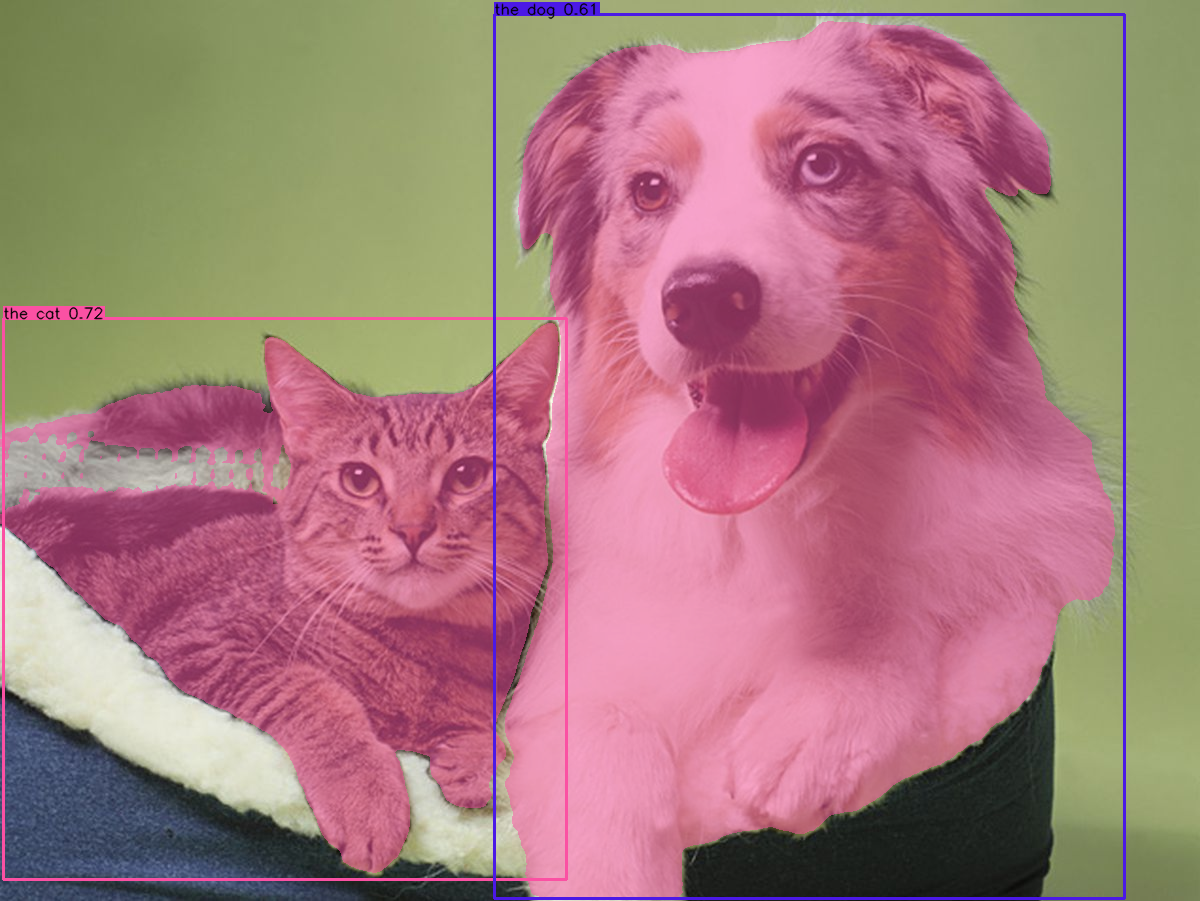

In [73]:
annotated_frame

### De-torch-lized

In [39]:
from copy import deepcopy
from typing import Tuple
from skimage.transform import resize

class ResizeLongestSide:
    """
    Resizes images to longest side 'target_length', as well as provides
    methods for resizing coordinates and boxes. Provides methods for
    transforming numpy arrays.
    """
    def __init__(self, target_length: int) -> None:
        self.target_length = target_length
        self.w, self.h, self.orig_w, self.orig_h = -1, -1, -1, -1

    def apply_image(self, image_pil) -> np.ndarray:
        """
        Expects a PILImage.
        """
        self.orig_w, self.orig_h = image_pil.size
        target_size = self.get_preprocess_shape()
        return np.array(image_pil.resize(target_size, Image.NEAREST))

    def apply_coords(self, coords: np.ndarray) -> np.ndarray:
        """
        Expects a numpy array of length 2 in the final dimension. Requires the
        original image size in (H, W) format.
        """
        new_h, new_w = self.get_preprocess_shape()
        coords = deepcopy(coords).astype(float)
        coords[..., 0] = coords[..., 0] * (new_w / self.orig_w)
        coords[..., 1] = coords[..., 1] * (new_h / self.orig_h)
        return coords

    def apply_boxes(self, boxes: np.ndarray) -> np.ndarray:
        """
        Expects a numpy array shape Bx4. Requires the original image size
        in (H, W) format.
        """
        boxes = self.apply_coords(boxes.reshape(-1, 2, 2))
        return boxes.reshape(-1, 4)

    def get_preprocess_shape(self) -> Tuple[int, int]:
        """
        Compute the output size given input size and target long side length.
        """
        if self.w < 0 and self.orig_w > 0:
            scale = self.target_length * 1.0 / max(self.orig_h, self.orig_w)
            newh, neww = self.orig_h * scale, self.orig_w * scale
            self.w = int(neww + 0.5)
            self.h = int(newh + 0.5)
        return (self.h, self.w)

    def postprocess_masks(self, masks: np.ndarray):
        return resize(masks, (1, self.orig_h, self.orig_w))

resizer = ResizeLongestSide(1024)

In [32]:
def sam_preprocess_image(image_pil):
    resized_image = resizer.apply_image(image_pil)
    resized_image = normalize(resized_image)
    resized_image = np.transpose(resized_image, (2, 0, 1))[None]
    h, w = resized_image.shape[-2:]
    padh = 1024 - h
    padw = 1024 - w
    img = np.pad(resized_image, ((0, 0), (0, 0), (0, padh), (0, padw)))
    return img

In [134]:
import torch
from torch.nn.functional import interpolate
def postprocess_masks(masks: np.ndarray):
    h, w, orig_h, orig_w = resizer.h, resizer.w, resizer.orig_h, resizer.orig_w
    masks = masks[..., :h, :w]
    masks = interpolate(torch.from_numpy(masks), size=(orig_h, orig_w), mode="bilinear", align_corners=False).numpy()
    return masks

In [117]:
#import cv2
# image_pil, image = load_image(image_path, [1024, 1024])
#image = cv2.imread('GroundingDINO/.asset/cat_dog.jpeg')
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
preprocessed_image = sam_preprocess_image(image_pil)
#image_pil_sam, image_sam = load_image('assets/cat_dog.jpeg', shape=[1024,1024])
encoding_results = sam_encoder(preprocessed_image)
image_embeddings = encoding_results[sam_encoder.output(0)]

In [125]:
detections.xyxy

array([[   3.66210938,  318.73754883,  566.16210938,  879.6628418 ],
       [ 494.82421875,   14.73803711, 1124.70703125,  898.58032227]])

In [74]:
boxes

array([[0.23742676, 0.66503906, 0.46875   , 0.6220703 ],
       [0.6748047 , 0.50683594, 0.52490234, 0.98095703]], dtype=float32)

In [136]:
masks = []
for box in detections.xyxy:
    coord = box.reshape(2,2)[None, :, :]
    label = np.array([2,3])[None, :].astype(np.float32)
    coord = resizer.apply_coords(coord)#.astype(np.float32)

    inputs = {
        "image_embeddings": image_embeddings,
        "point_coords": coord,
        "point_labels": label,
    }
    results = sam_predict(inputs)

    mask = results[sam_predict.output(0)]
    mask = postprocess_masks(mask)
    mask = mask > 0.0
    masks.append(mask)

In [129]:
masks[0][0].shape

(1, 901, 1200)

In [110]:
np.array(image_pil).shape

(901, 1200, 3)

In [112]:
import cv2
#image_pil, image = load_image(image_path, [1024, 1024])
image = cv2.imread('assets/cat_dog.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#image = cv2.resize(image, (1024, 1024))

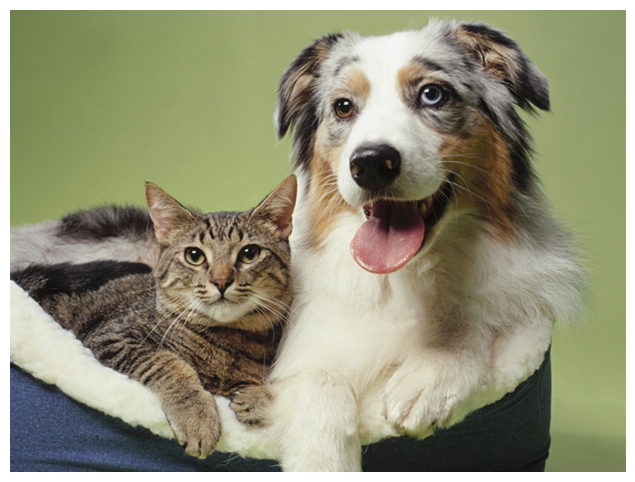

In [130]:
plt.figure(figsize=(8,6))
plt.imshow(image)
plt.axis('off')
plt.show()

In [137]:
box_annotator = sv.BoxAnnotator()
mask_annotator = sv.MaskAnnotator()
annotated_image = np.array(image_pil)
for mask in masks:
    detections.mask = mask[0]#resizer.postprocess_masks(mask[0])
    annotated_image = mask_annotator.annotate(scene=annotated_image, detections=detections)
labels = [f"{p} {c:.2f}" for p, c in zip(phrases, detections.confidence.tolist())]
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)


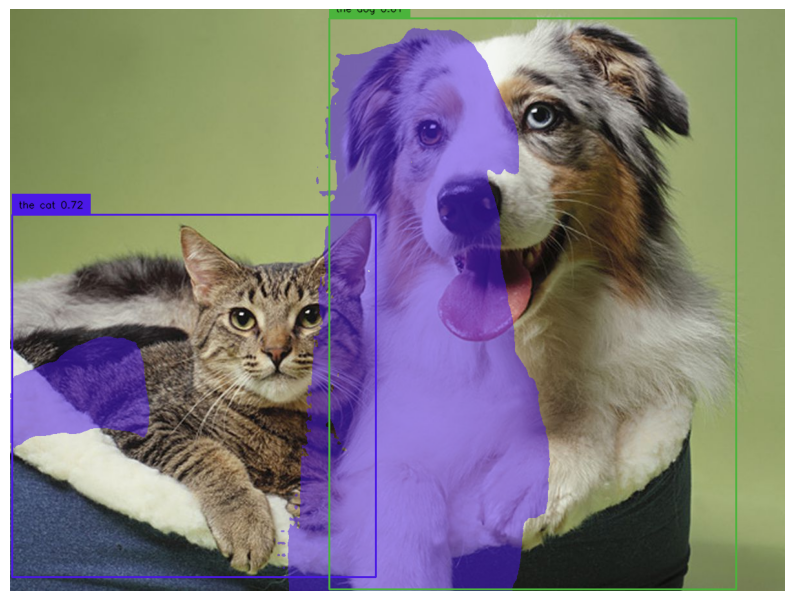

In [138]:
plt.figure(figsize=(10, 10))
plt.imshow(annotated_image)
plt.axis('off')
plt.show()